In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install accelerate -U
# !pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [3]:
import re
import nltk
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset, load_metric
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/colabTextSummarization/LogDataset.csv")
dataset.head()

,Task Description,Summary
0,"1. Meeting list, task list design, set their p...",describes a series of tasks related to designi...
1,1. Food app few design research.\n2. About foo...,There are many tasks related to designing and ...
2,1. Daily work update & new requirement.\n2. EB...,daily work updates and new requirements for va...
3,Absolutely! Here is a structured list of the t...,The employee's work focused primarily on commu...
4,1. Analyzing the ThriveDesk website and docume...,"analyzed and documented several websites, incl..."


In [5]:
shuffled_dataframe = dataset.sample(frac=1).reset_index(drop=True)
shuffled_dataframe.rename(columns={'Task Description': 'dialogue', 'Summary': 'summary'}, inplace=True)

In [6]:

# # Function to clean and lemmatize text
# def clean_and_lemmatize(text):
#     # Remove digits, symbols, punctuation marks, and newline characters
#     text = re.sub(r'\d+', '', text)
#     text = re.sub(r'[^\w\s]', '', text.replace('\n', ''))
#     # Tokenize the text
#     tokens = word_tokenize(text.lower())
#     # Initialize lemmatizer
#     lemmatizer = WordNetLemmatizer()
#     # Get English stopwords
#     stop_words = set(stopwords.words('english'))
#     # Lemmatize each token and remove stop words, then join back into a sentence
#     cleaned_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens if token not in stop_words])
#     # Retype the line below to ensure there are no hidden characters
#     return cleaned_text
# # Apply cleaning and lemmatization to the 'Task Description' column
# shuffled_dataframe['dialogue'] = shuffled_dataframe['dialogue'].apply(clean_and_lemmatize)
# shuffled_dataframe['summary'] = shuffled_dataframe['summary'].apply(clean_and_lemmatize)

In [7]:
def clean_and_lemmatize(text):
    # Remove digits, symbols, punctuation marks, and newline characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text.replace('\n', ''))
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each token and join back into a sentence
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text
# Apply cleaning and lemmatization to the 'Task Description' column
shuffled_dataframe['dialogue'] = shuffled_dataframe['dialogue'].apply(clean_and_lemmatize)
shuffled_dataframe['summary'] = shuffled_dataframe['summary'].apply(clean_and_lemmatize)

In [8]:
shuffled_dataframe.head()

,dialogue,summary
0,food app few design research about food app ne...,there are many task related to designing and p...
1,absolutely here is a structured list of the ta...,the employee work focused primarily on communi...
2,fixed the bar chart bar chart design added bar...,fixing an unspecified problem with the chart p...
3,fixed issue of data fetching fixed whatsapp up...,fixed several issue including data fetching an...
4,creating a custom app bar for the new food sav...,focused on the food saver app creating custom ...


In [9]:
train_dataset = shuffled_dataframe.iloc[:28]
test_dataset = shuffled_dataframe.iloc[28:]

In [10]:
train_dataset.head()

,dialogue,summary
0,food app few design research about food app ne...,there are many task related to designing and p...
1,absolutely here is a structured list of the ta...,the employee work focused primarily on communi...
2,fixed the bar chart bar chart design added bar...,fixing an unspecified problem with the chart p...
3,fixed issue of data fetching fixed whatsapp up...,fixed several issue including data fetching an...
4,creating a custom app bar for the new food sav...,focused on the food saver app creating custom ...


In [11]:
train_dataset.head()

,dialogue,summary
0,food app few design research about food app ne...,there are many task related to designing and p...
1,absolutely here is a structured list of the ta...,the employee work focused primarily on communi...
2,fixed the bar chart bar chart design added bar...,fixing an unspecified problem with the chart p...
3,fixed issue of data fetching fixed whatsapp up...,fixed several issue including data fetching an...
4,creating a custom app bar for the new food sav...,focused on the food saver app creating custom ...


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
dialogue_len = [len(x.split()) for x in train_dataset['dialogue']]
summary_len = [len(x.split()) for x in train_dataset['summary']]

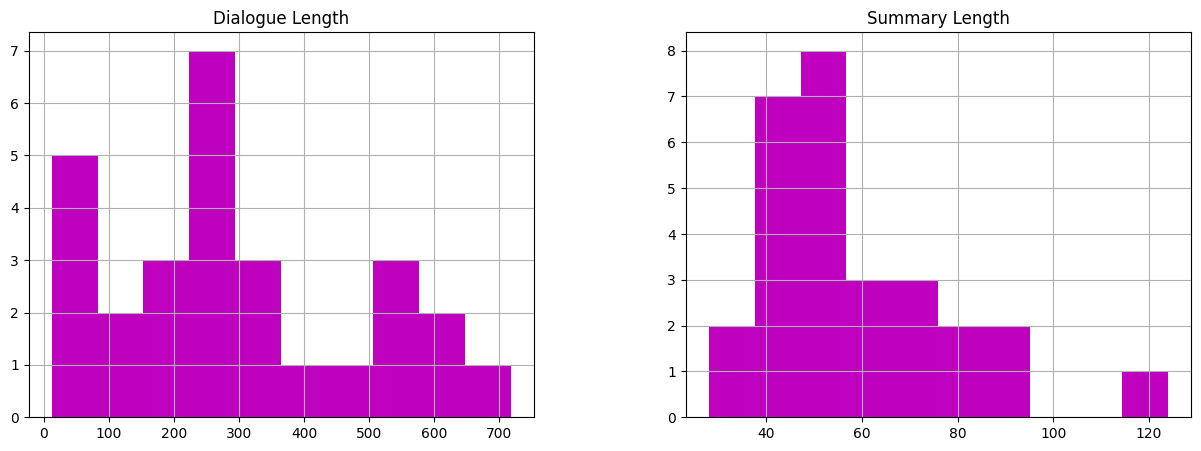

In [14]:
data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']
data.hist(figsize=(15,5), color = "m");

In [15]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [16]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=8, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=800,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=85)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        # decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        # print(decoded_summaries)

        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [17]:
pipe = pipeline('summarization', model = model_ckpt )
pipe_out = pipe(train_dataset['dialogue'][0]);

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
train_dataset['dialogue'][0]

'food app few design research about food app new feature food app homepage design research some food ui design food detail page complete ui design food category page complete ui design food app recommended for you page research design food app category breakfast page research design food app category food detail page research design food app food near you page research design food app restaurant list page research design food app restaurant food detail page research design food app post product page research design food app few design error fix color palate change button making new requirement about the food app food app selling item page research design food app selling item food detail page research design food app app info app info page research animation add food app splash screen page chef vector research input in screen daily work update new work assign food app profile edit profile page ui research design complete food app home without log in page ui research design complete new

In [19]:
pipe_out

[{'summary_text': 'food app few design error fix color palate change button eb call detail implementation freelancer website gig making other privacy policy checking eb calendar design change daily work update new requirement eb user profile new requirement ui design about eb user profile new requirement eb adding billing module ui design daily work update and new requirement eb adding billing module ui design about rajshahi office daily work update and new requirement eb home page design change insightdb loading screen ui change about rajshahi office daily work update new requirement eb calendar design change ui design implement daily work update new requirement eb lead form reduce'}]

In [20]:
train_dataset['summary'][0]

'there are many task related to designing and prototyping screen for the food app including homepage food detail category recommended food breakfast category food detail in category food near you restaurant list restaurant food detail post product selling item selling item food detail app info splash screen profile edit profile home without log in billing module there are also task related to eb including call detail calendar design adding billing module home page ui design insightdb loading screen ui change form design activity page ui research'

In [21]:
print(pipe_out[0]['summary_text'].replace(" .", ".\n"))

food app few design error fix color palate change button eb call detail implementation freelancer website gig making other privacy policy checking eb calendar design change daily work update new requirement eb user profile new requirement ui design about eb user profile new requirement eb adding billing module ui design daily work update and new requirement eb adding billing module ui design about rajshahi office daily work update and new requirement eb home page design change insightdb loading screen ui change about rajshahi office daily work update new requirement eb calendar design change ui design implement daily work update new requirement eb lead form reduce


In [22]:
# train_dataset = train_dataset.iloc[:2000]
# test_dataset = test_dataset.iloc[:1800]

# Create a datasets.Dataset object
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)
# Print the dataset to check the format
print("Train Dataset : ",train_dataset)
print("Test Dataset : ", test_dataset)

Train Dataset :  Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 28
})
Test Dataset :  Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 7
})


In [23]:
rouge_metric = load_metric('rouge')
score = calculate_metric_on_test_ds(train_dataset,
                                    rouge_metric,
                                    model_pegasus,
                                    tokenizer,
                                    column_text = 'dialogue',
                                    column_summary='summary',
                                    batch_size=4);

<ipython-input-23-13da56a6946d>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
100%|██████████| 7/7 [00:30<00:00,  4.32s/it]


In [24]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.311323,0.082163,0.218457,0.218986


In [25]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 512, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 90, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_train = train_dataset.map(convert_examples_to_features, batched = True)
dataset_samsum_test = test_dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [26]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [27]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum',
    num_train_epochs=200,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)



In [28]:
trainer = Trainer(model=model_pegasus,
                  args=trainer_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_train,
                  eval_dataset=dataset_samsum_test)

In [29]:
trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=200, training_loss=4.310153675079346, metrics={'train_runtime': 874.6921, 'train_samples_per_second': 6.402, 'train_steps_per_second': 0.229, 'total_flos': 2674543567945728.0, 'train_loss': 4.310153675079346, 'epoch': 114.29})

In [30]:
score = calculate_metric_on_test_ds(
    test_dataset, rouge_metric, trainer.model, tokenizer, batch_size = 4, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 2/2 [00:08<00:00,  4.50s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.325642,0.101139,0.238902,0.236636


In [31]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

In [32]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [33]:
tokenizer = AutoTokenizer.from_pretrained("/content/tokenizer")
sample_text = test_dataset["dialogue"][0]
sample_text = clean_and_lemmatize(sample_text)
reference = test_dataset["summary"][0]
gen_kwargs = {"length_penalty": 0.4, "num_beams": 8, "max_length": 50}

pipe = pipeline("summarization", model="/content/pegasus-samsum-model", tokenizer=tokenizer)
print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


Dialogue:
create audio card design image card check out bottom bar create tag list screen create a row with icon create feeling screen create task dialog create a tag card change design create photo view screen implement dynamic photo list using getx make a custom modal sheet work on audio record implement function for audio recorder implement dynamic audio card complete audio player work on location get eb user and pic and name implement dynamic image card get form field value get account from local db implement dynamic initiate form implement dynamic next form update db value add note to local db get note from local db update note dynamically add route to single image add multiple image add multiple image picker complete checkin detail and view complete checkin post change variable and clean code fix feedback add new field to popup dialog add edit screen implement crop image widget implement edit image widget create bill function schema create insert function create delete function c